# **Policy Gradient**

First of all let's import the required libraries:

In [1]:
# Gym library
import gymnasium as gym

# Go one level up to import the agent
import sys
sys.path.append('..')

# Import custom class for Policy Gradient Agent
from src.agents import PolicyGradientAgent

Now let's load the corresponding environment:

In [2]:
# Define the environment
env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode='rgb_array')
# Reset the environment
env.reset()

((20, 9, 0), {})

A class `PolicyGradientAgent` has been created in `src/agents.py` in order to implement the policy gradient algorithm. Let's instantiate it:

In [3]:
# Define the agent
agent = PolicyGradientAgent(
    env=env, 
    num_states=3, 
    num_actions=2, 
    gamma=0.99
    )

Now let's train the agent:

In [4]:
train_rewards, mean_train_rewards = agent.train(
    n_iterations=1000, 
    n_episodes_per_update=16, 
    )

Iteration: 1000/1000, mean reward: -0.4  

It would be interesting to see how many wins, ties and losses the agent has achieved during training, in percentage:

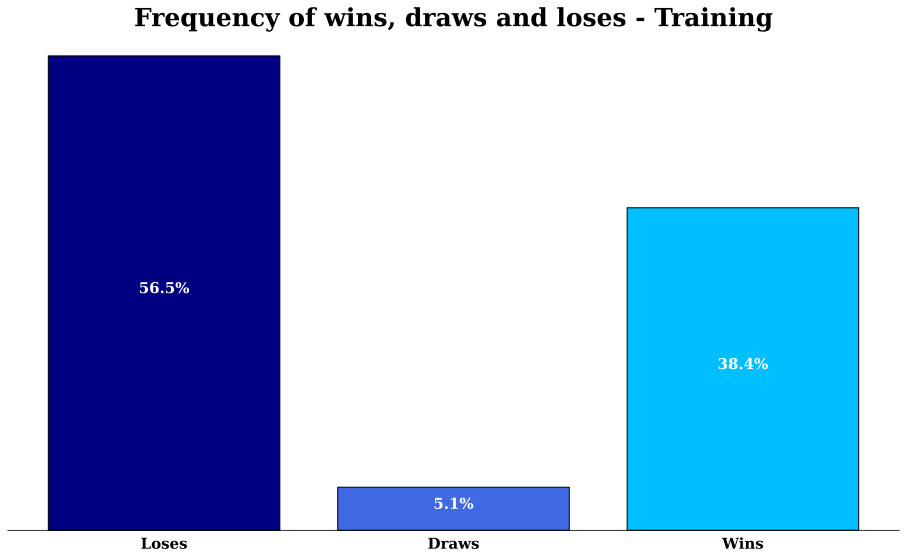

In [5]:
agent.plot_performance(
    rewards=train_rewards,
    title="Frequency of wins, draws and loses - Training",
    color=["navy", "royalblue", "deepskyblue"]
    )

Once the agent has been trained, we can evaluate its performance:

In [6]:
evaluation_rewards = agent.evaluate(n_episodes=1000)

Let's see how many wins, ties and losses the agent has achieved during evaluation, in percentage:

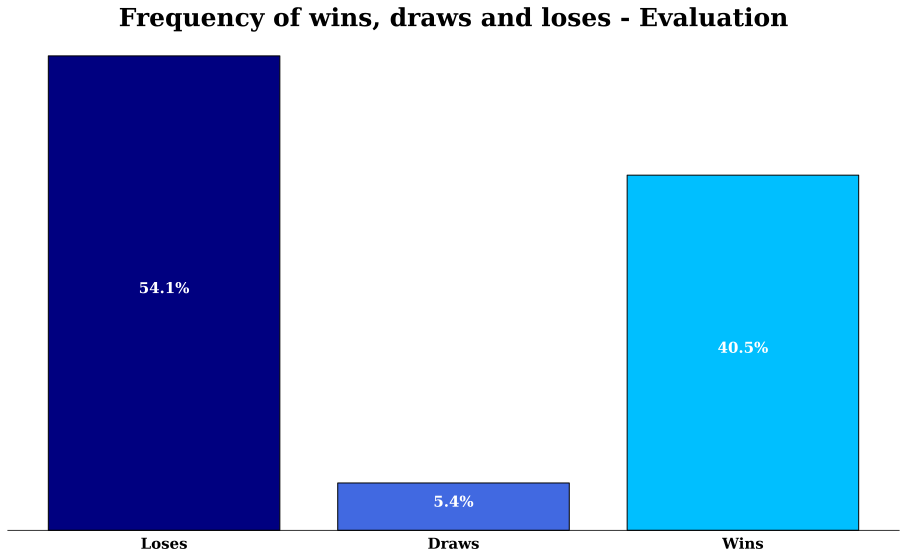

In [7]:
agent.plot_performance(
    rewards=evaluation_rewards,
    title="Frequency of wins, draws and loses - Evaluation",
    color=["navy", "royalblue", "deepskyblue"]
    )

Finally, let's save the model:

In [8]:
agent.save(
    model_dir="../models",
    model_name="policy_gradient_agent.h5",
    )